# PD7

Task: detect outliers with GMM algorithm. Check model's F1 score, Precision and Recoll. 

In [1]:
import pandas as pd
from sklearn import mixture, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")
df_test_X = df_test.iloc[:,1:]
df_test_y = df_test.iloc[:,0]


def get_scores(y_true, y_pred, metric_types=['macro', 'micro','weighted']):
    return pd.DataFrame(
                data=[precision_recall_fscore_support(y_true, y_pred, average=metric_type) for metric_type in metric_types],
                index=metric_types, 
                columns=['precision','recall','F1 score','support']).iloc[:,:3]

## Train GMM

In [2]:
gmm = mixture.GaussianMixture(n_components=1,covariance_type='full')
gmm.fit(df_train);

## Find threshold for outliers

First, I plot the weighted log probabilities for each sample in training data.

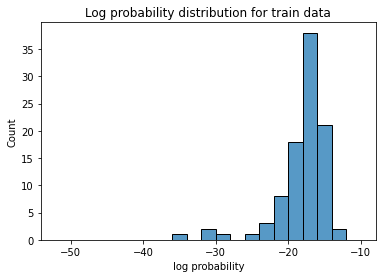

In [3]:
logprob_train = gmm.score_samples(df_train)
logprob_valid = gmm.score_samples(df_val)

ax = sns.histplot(logprob_train,binrange=(-52,-10),binwidth=2)
ax.set_title('Log probability distribution for train data')
ax.set_xlabel('log probability');

In [4]:
min(logprob_train)

-35.632145622230794

Then, I plot the weighted log probabilities for each sample in validation data.

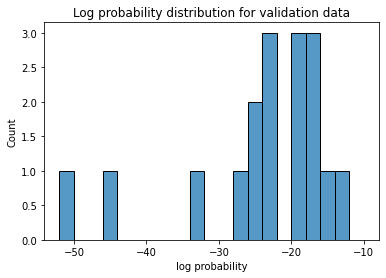

In [5]:
ax = sns.histplot(logprob_valid,binrange=(-52,-10),binwidth=2)
ax.set_title('Log probability distribution for validation data')
ax.set_xlabel('log probability');

Next I choose a value to separate outliers from the correct samples.

In [6]:
outliers_threshold = -30 # although it does classify some data from the training set as outliers 

Lastly, I plot the results for validation data (data after PCA for easier plotting). There are 2 blue dots on the right - these are the 2 outliers from the validation set. Transparent blue dots represent training data, light yellow and green show points from validation set (outliers are in dark blue).

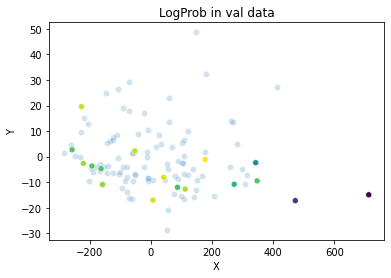

In [7]:
pca = PCA(n_components=2)
pca.fit(df_train)
df_train_pca = pca.transform(df_train)
df_val_pca = pca.transform(df_val)

sns.scatterplot(data=pd.DataFrame(df_train_pca, columns=['X','Y']), x='X', y='Y',alpha=0.2)
ax = sns.scatterplot(data=pd.DataFrame(df_val_pca, columns=['X','Y']), x='X', y='Y', c=logprob_valid)
ax.set_title('LogProb in val data');

The same plot but with labels instead of a range of colors. Here, False (blue) are not outliers from validation set and True (orange) are outliers. Transparent blue dots are dots from training data.

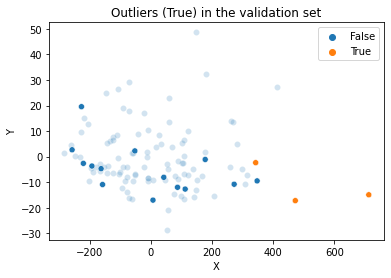

In [8]:
sns.scatterplot(data=pd.DataFrame(df_train_pca, columns=['X','Y']), x='X', y='Y',alpha=0.2)
ax = sns.scatterplot(data=pd.DataFrame(df_val_pca, columns=['X','Y']), x='X', y='Y', hue=logprob_valid<outliers_threshold)
ax.set_title('Outliers (True) in the validation set');

## Outliers in the Test set

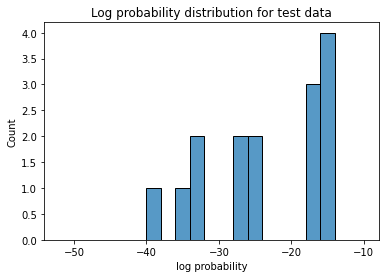

In [9]:
logprob_test = gmm.score_samples(df_test_X)
ax = sns.histplot(logprob_test,binrange=(-52,-10),binwidth=2)
ax.set_title('Log probability distribution for test data')
ax.set_xlabel('log probability');

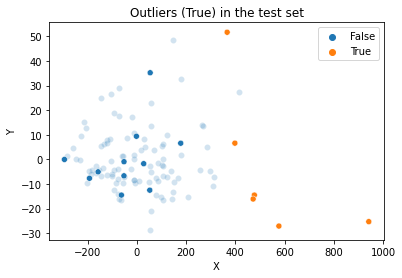

In [10]:
df_test_X_pca = pca.transform(df_test_X)
sns.scatterplot(data=pd.DataFrame(df_train_pca, columns=['X','Y']), x='X', y='Y',alpha=0.2)
ax = sns.scatterplot(data=pd.DataFrame(df_test_X_pca, columns=['X','Y']), x='X', y='Y', hue=logprob_test<outliers_threshold)
ax.set_title('Outliers (True) in the test set');

## Metrics

In [11]:
# train set
get_scores([0]*len(df_train), logprob_train<outliers_threshold, metric_types=['weighted'])

C:\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,F1 score
weighted,1.0,0.968421,0.983957


In [12]:
# test set
get_scores(df_test_y, logprob_test<outliers_threshold)

,precision,recall,F1 score
macro,0.916667,0.958333,0.932806
micro,0.941176,0.941176,0.941176
weighted,0.950980,0.941176,0.942571


## Summary

Gaussian Mixture model can be used to detect outliers even in the data that has not been scaled with some scalers.